## Electron resolution study

One of the reasons for this is to understand better why the electron method resolution gets very bad at low y.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import math

import uproot3

rc('text', usetex=True)

import matplotlib as mpl

mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

ebeam_e = 27.6
ebeam_p = 920



#infile_name = 'mini-tree.root-save-2021-07-17a'
#infile_name = 'mini-tree-badres-10percent-constant.root'
#infile_name = 'mini-tree-badres-20percent-constant.root'
infile_name = 'mini-tree-gen-HFS-etamax4.0.root'

infile_name_fullsim = 'h1-fullsim-2021-07-19/h1fullsim-5files.root'





/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
print('\n Loading fastsim minitree\n')
ur_file = uproot3.open(infile_name)
print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
mc   =  ur_tree.pandas.df(['*'], entrystop=3e7,flatten=True)
mc

print('\n Done \n')


 Loading fastsim minitree

[b'minitree;1']
<TTree b'minitree' at 0x00011d901790>

 Done 



## Do all of the calculations and save results as columns in the dataframe

In [17]:
def do_calculations( df ):
    
    temp = df

    temp['e_pt'] = np.sqrt( temp['e_px']*temp['e_px'] + temp['e_py']*temp['e_py'])
    temp['e_theta'] = np.arctan2( temp['e_pt'], temp['e_pz'])
    temp['e_e'] = np.sqrt( temp['e_px']*temp['e_px'] + temp['e_py']*temp['e_py'] + temp['e_pz']*temp['e_pz'])
    temp['e_Empz'] = temp['e_e'] - temp['e_pz']
    temp['gen_e_pz'] = temp['gen_e_e'] * np.cos( temp['gen_e_theta'] )
    temp['e_eta'] = -1.0 * np.log( np.tan( temp['e_theta'] / 2. ))
    temp['gen_e_Empz'] = temp['gen_e_e'] - temp['gen_e_pz']
    
    temp.eval( 's = 4*27.6*920', inplace=True)
    
    
    temp.eval( 'dx_e_norm = (x_e - gen_x) / gen_x', inplace=True )    
    
    temp.eval( 'dy_e_norm = (y_e - gen_y) / gen_y', inplace=True )
    
    
    temp.eval( 'de_pt_norm = (e_pt-gen_e_pt)/gen_e_pt', inplace=True )
    temp.eval( 'de_e_norm = (e_e - gen_e_e)/gen_e_e', inplace=True )
    temp.eval( 'de_Empz_norm = (e_e - e_pz - (gen_e_e - gen_e_pz))/(gen_e_e - gen_e_pz)', inplace=True )
    temp.eval( 'de_pz_norm = (e_pz-gen_e_pz)/gen_e_pz', inplace=True )
    temp.eval( 'de_eta_norm = (e_eta-gen_e_eta)/gen_e_eta', inplace=True )
    temp.eval( 'de_theta_norm = (e_theta-gen_e_theta)/gen_e_theta', inplace=True )
    
    temp['dx_e_norm_over_de_Empz_norm'] = temp['dx_e_norm'] / temp['de_Empz_norm']
    
    temp['dx_e_norm_over_de_pt_norm'] = temp['dx_e_norm'] / temp['de_pt_norm']
    
    
    temp.eval('partial_x_wrt_E = gen_x/gen_e_e + (gen_x/gen_y)*(sin(gen_e_theta/2)*sin(gen_e_theta/2)/27.6)', inplace=True )

    temp.eval('partial_x_wrt_E__times__dE = partial_x_wrt_E * (e_e-gen_e_e)', inplace = True )
    
    temp.eval('partial_x_wrt_E__times__dE__over__x = partial_x_wrt_E * (e_e-gen_e_e) / gen_x', inplace = True )
    
    
    temp.eval('partial_x_wrt_theta = gen_x * gen_e_e * ( 1/(gen_y * beam_electron_energy) - 4 * beam_electron_energy / gen_Q2 ) * sin(gen_e_theta/2) * cos(gen_e_theta/2)', inplace = True )

    
    #-- width of theta - gen_theta is around 0.00225 in fullsim.  There's no theta smearing in fastsim.
    
    temp.eval('partial_x_wrt_theta__times__dtheta = partial_x_wrt_theta * (0.00225)', inplace = True )
    
    temp.eval('partial_x_wrt_theta__times__dtheta__over__x = partial_x_wrt_theta * (0.00225) / gen_x', inplace = True )
    
    return temp
    

In [18]:
mc = do_calculations( mc )

In [19]:
mc[['partial_x_wrt_E', 'partial_x_wrt_E__times__dE', 'partial_x_wrt_E__times__dE__over__x']]

,partial_x_wrt_E,partial_x_wrt_E__times__dE,partial_x_wrt_E__times__dE__over__x
entry,,,
0,0.457609,-0.739443,-2.789356
1,0.006837,-0.008755,-0.123900
2,0.001424,0.000103,0.011190
3,0.001335,-0.001080,-0.128153
4,0.000628,0.000485,0.092431
...,...,...,...
82850,0.231336,0.302071,1.380063
82851,0.001142,0.000023,0.002647
82852,0.003125,-0.004504,-0.136008


In [20]:
mc[['partial_x_wrt_theta','partial_x_wrt_theta__times__dtheta','partial_x_wrt_theta__times__dtheta__over__x']]

,partial_x_wrt_theta,partial_x_wrt_theta__times__dtheta,partial_x_wrt_theta__times__dtheta__over__x
entry,,,
0,5.111382,0.011501,0.043383
1,0.101765,0.000229,0.003240
2,-0.017824,-0.000040,-0.004352
3,-0.017940,-0.000040,-0.004788
4,-0.008412,-0.000019,-0.003606
...,...,...,...
82850,2.952729,0.006644,0.030353
82851,-0.015021,-0.000034,-0.003957
82852,0.004270,0.000010,0.000290


## Look at analytical resolution using partial derivatives wrt E and theta for electron

From these plots, it seems as though it's entirely the electron energy, not theta.

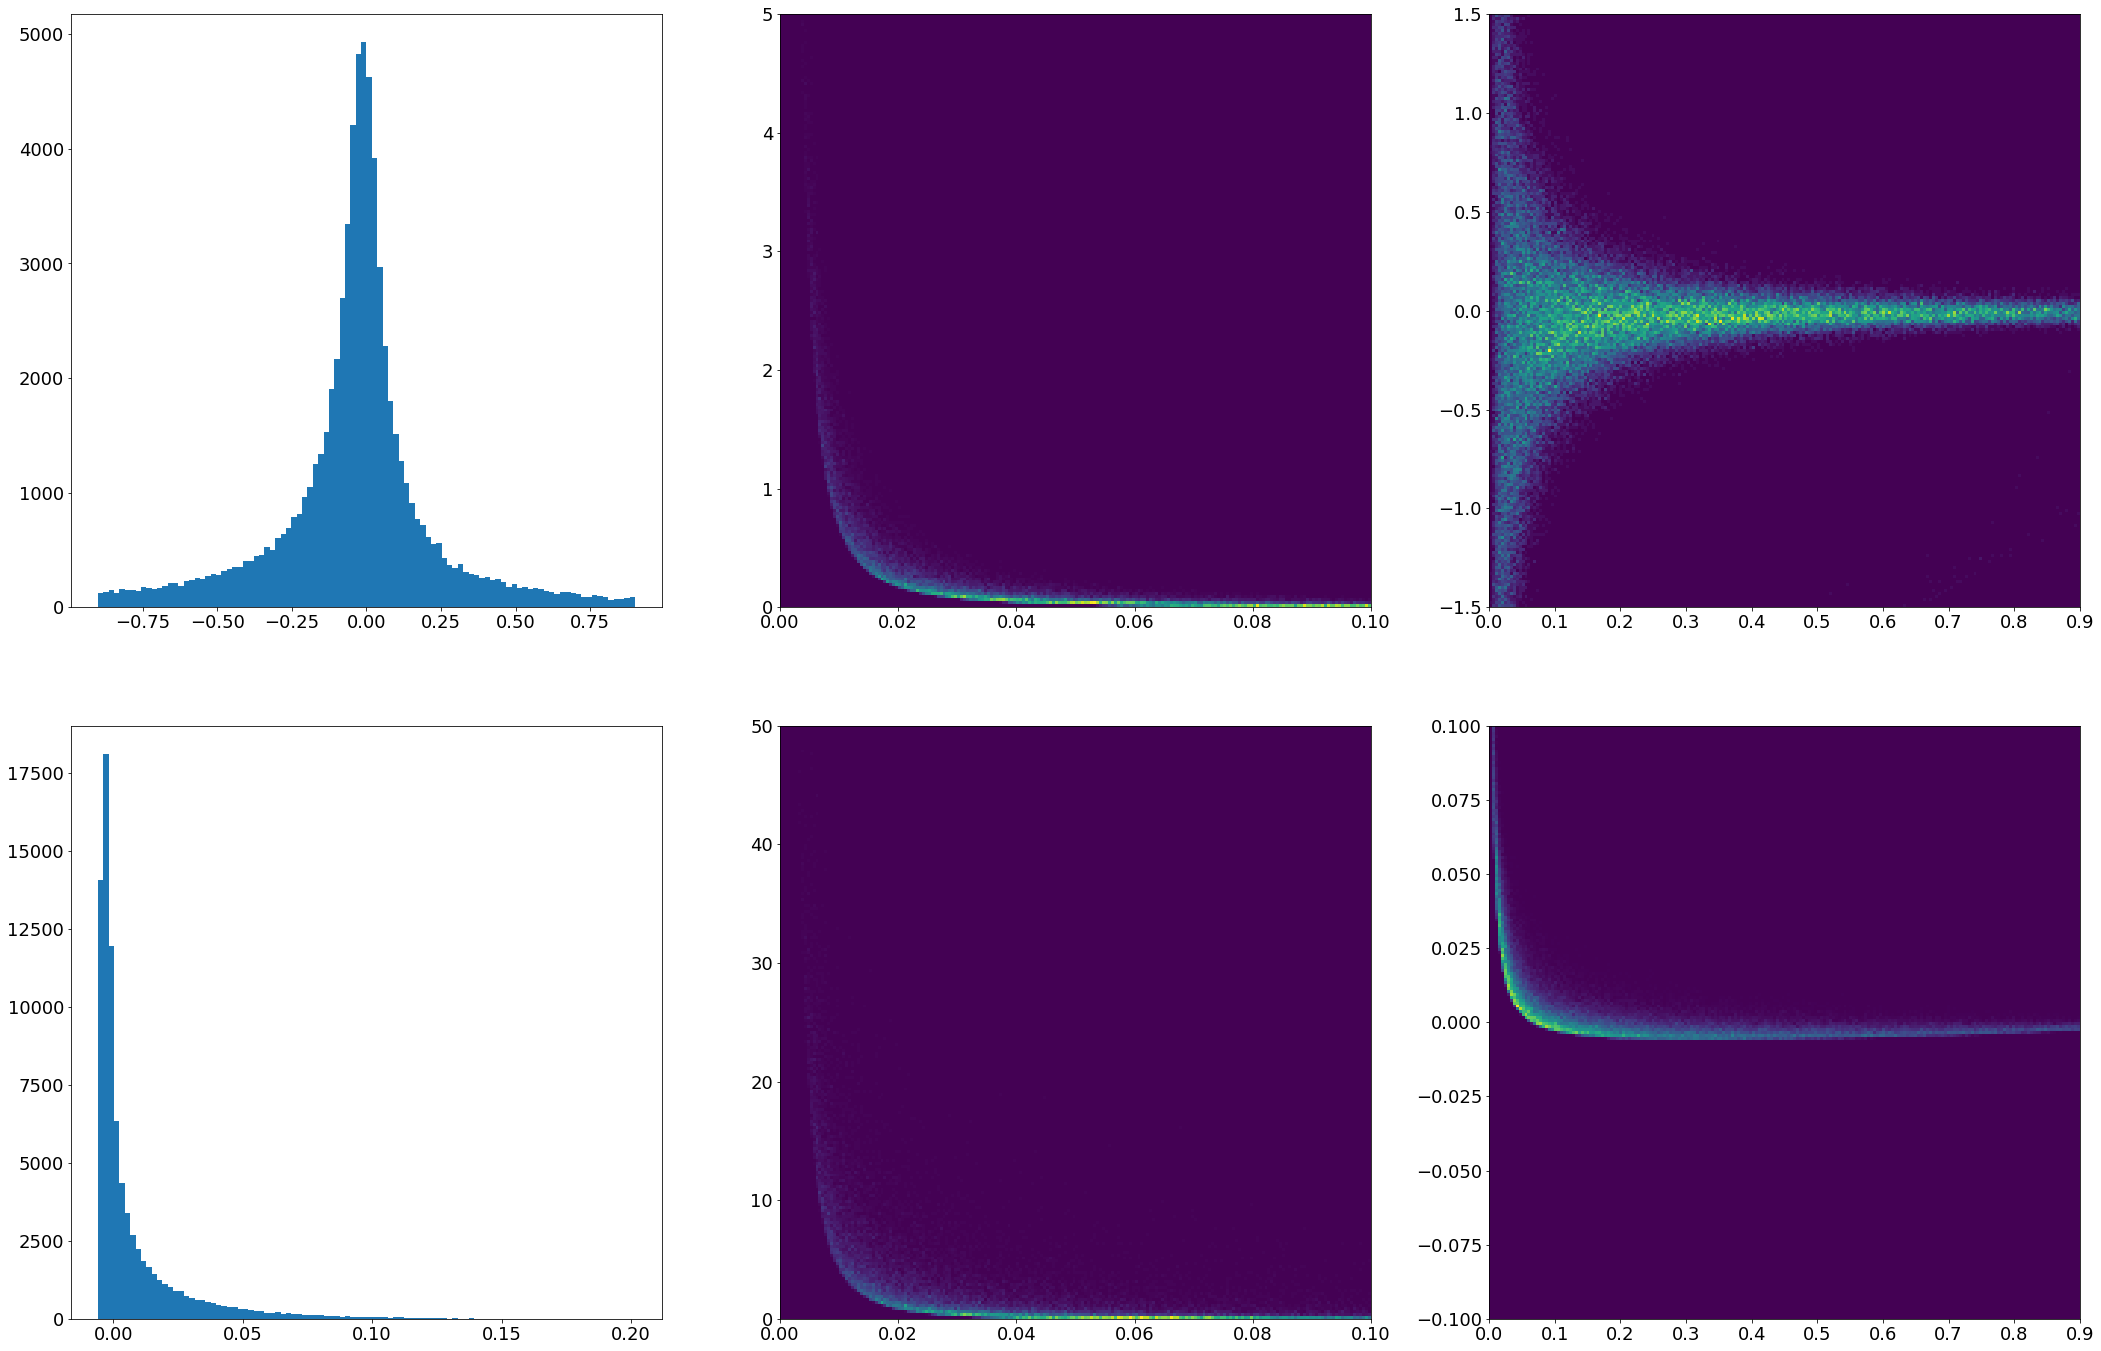

In [22]:
cuts = 'gen_y < 1'

fig,ax = plt.subplots(2,3,figsize=(36,24))

ax[0][0].hist( mc.query(cuts)['partial_x_wrt_E__times__dE__over__x'], range=[-0.9,0.9], bins=100)
ax[0][1].hist2d( mc.query(cuts)['gen_y'], mc.query(cuts)['partial_x_wrt_E'], range=([0,0.1],[0,5]), bins=200  )
ax[0][2].hist2d( mc.query(cuts)['gen_y'], mc.query(cuts)['partial_x_wrt_E__times__dE__over__x'], range=([0,0.9],[-1.5,1.5]), bins=200  )

ax[1][0].hist( mc.query(cuts)['partial_x_wrt_theta__times__dtheta__over__x'], bins=100)
ax[1][1].hist2d( mc.query(cuts)['gen_y'], mc.query(cuts)['partial_x_wrt_theta'], range=([0,0.1],[0,50]), bins=200  )
ax[1][2].hist2d( mc.query(cuts)['gen_y'], mc.query(cuts)['partial_x_wrt_theta__times__dtheta__over__x'], range=([0,0.9],[-0.1,0.1]), bins=200 )

plt.show()


In [5]:
mc[['e_e','gen_e_e','e_pt','gen_e_pt','e_pz','gen_e_pz','de_pt_norm','de_e_norm','de_Empz_norm','de_pz_norm']]

,e_e,gen_e_e,e_pt,gen_e_pt,e_pz,gen_e_pz,de_pt_norm,de_e_norm,de_Empz_norm,de_pz_norm
entry,,,,,,,,,,
0,29.953049,31.568933,20.895912,22.023188,-21.460335,-22.618065,-0.051186,-0.051186,-0.051186,-0.051186
1,36.541519,37.822075,36.474258,37.752453,-2.216146,-2.293809,-0.033857,-0.033857,-0.033857,-0.033858
2,22.038351,21.965931,13.992063,13.946084,-17.026775,-16.970825,0.003297,0.003297,0.003297,0.003297
3,21.057890,21.867443,12.771819,13.262822,-16.742620,-17.386276,-0.037021,-0.037021,-0.037021,-0.037021
4,14.656804,13.883825,11.928894,11.299782,-8.516068,-8.066943,0.055675,0.055675,0.055675,0.055675
...,...,...,...,...,...,...,...,...,...,...
82850,33.943382,32.637615,26.016937,25.016092,-21.800737,-20.962086,0.040008,0.040008,0.040008,0.040008
82851,20.364050,20.344259,14.213531,14.199718,-14.583213,-14.569040,0.000973,0.000973,0.000973,0.000973
82852,27.217850,28.659105,26.587864,27.995762,-5.822094,-6.130389,-0.050290,-0.050290,-0.050290,-0.050290


In [24]:
mc[['dx_e_norm','de_Empz_norm','dx_e_norm_over_de_Empz_norm']]

,dx_e_norm,de_Empz_norm,dx_e_norm_over_de_Empz_norm
entry,,,
0,-0.746183,-0.051186,14.577878
1,-0.113666,-0.033857,3.357195
2,0.011279,0.003297,3.421242
3,-0.117449,-0.037021,3.172510
4,0.095958,0.055675,1.723539
...,...,...,...
82850,-4.058352,0.040008,-101.438522
82851,0.002651,0.000973,2.725554
82852,-0.125270,-0.050290,2.490972


In [6]:
cuts = 'gen_y < 1'

cuts : gen_y < 1


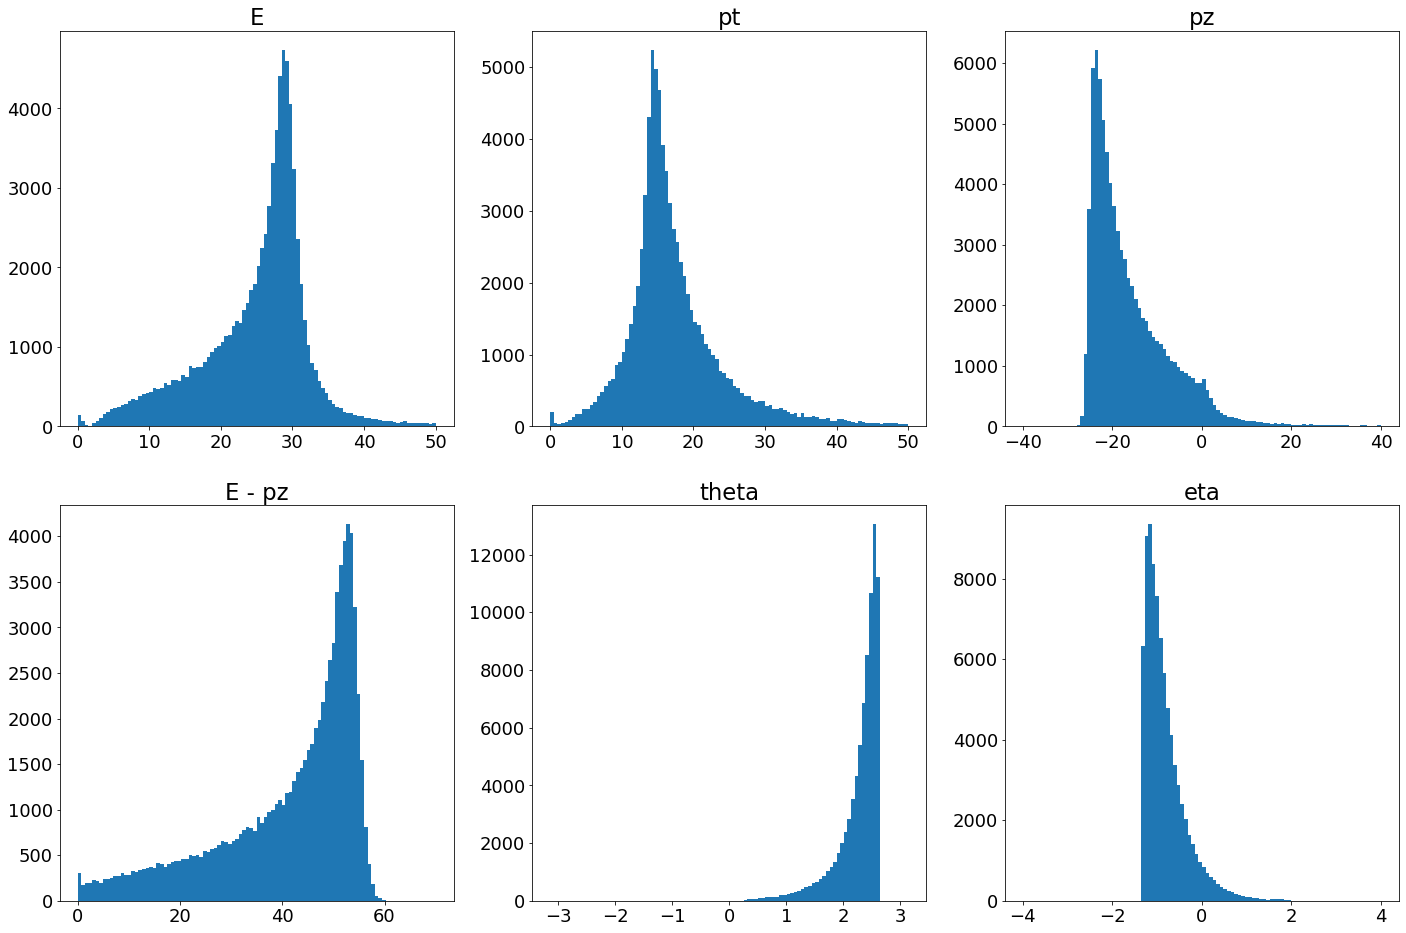

In [7]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

ax[0][0].hist(mc.query(cuts)['e_e'], range=[0,50], bins=100 )
ax[0][1].hist(mc.query(cuts)['e_pt'], range=[0,50], bins=100 )
ax[0][2].hist(mc.query(cuts)['e_pz'], range=[-40,40], bins=100 )

ax[1][0].hist(mc.query(cuts)['e_Empz'], range=[0,70], bins=100 )
ax[1][1].hist(mc.query(cuts)['e_theta'], range=[-3.1415,3.1415], bins=100 )
ax[1][2].hist(mc.query(cuts)['e_eta'], range=[-4,4], bins=100 )

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

plt.show()

cuts : gen_y < 1


 gen x vs various gen-e things


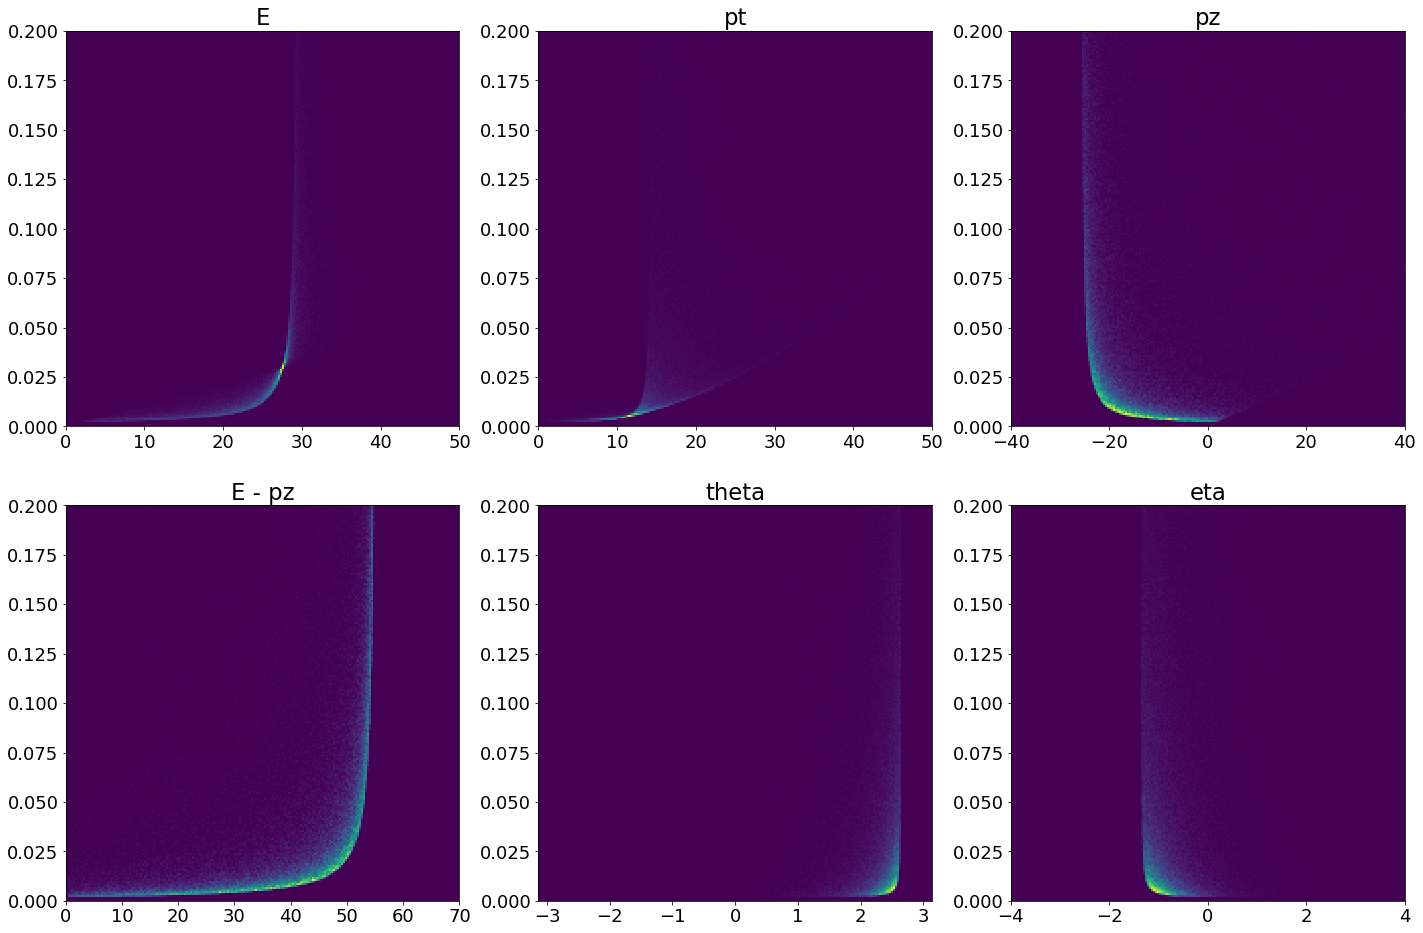

In [8]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

max_gen_x = 0.2

ax[0][0].hist2d(  mc.query(cuts)['gen_e_e'],  mc.query(cuts)['gen_x'], range=([0,50],[0,max_gen_x],), bins=200)
ax[0][1].hist2d(  mc.query(cuts)['gen_e_pt'], mc.query(cuts)['gen_x'],  range=([0,50],[0,max_gen_x],), bins=200)
ax[0][2].hist2d(  mc.query(cuts)['gen_e_pz'], mc.query(cuts)['gen_x'],  range=([-40,40],[0,max_gen_x],), bins=200)

ax[1][0].hist2d( mc.query(cuts)['gen_e_Empz'],  mc.query(cuts)['gen_x'],  range=([0,70],[0,max_gen_x],), bins=200)
ax[1][1].hist2d( mc.query(cuts)['gen_e_theta'], mc.query(cuts)['gen_x'],   range=([-3.1415,3.1415],[0,max_gen_x],), bins=200)
ax[1][2].hist2d( mc.query(cuts)['gen_e_eta'], mc.query(cuts)['gen_x'],   range=([-4,4],[0,max_gen_x],), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n gen x vs various gen-e things')

plt.show()

cuts : gen_y < 1


 gen x vs various reconstructed e things


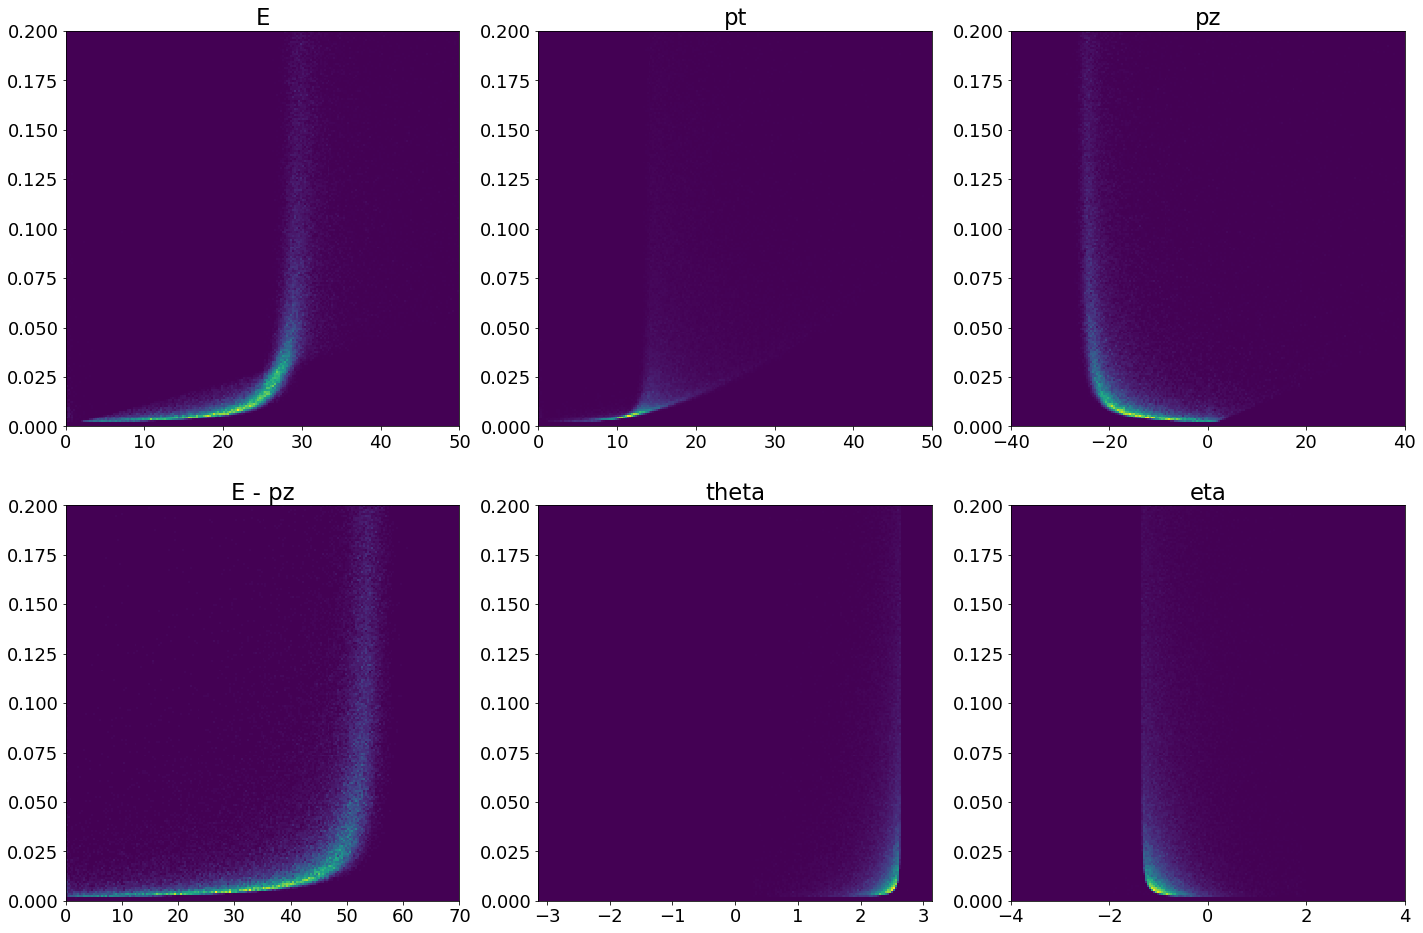

In [9]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

max_gen_x = 0.2

ax[0][0].hist2d(  mc.query(cuts)['e_e'],  mc.query(cuts)['gen_x'], range=([0,50],[0,max_gen_x],), bins=200)
ax[0][1].hist2d(  mc.query(cuts)['e_pt'], mc.query(cuts)['gen_x'],  range=([0,50],[0,max_gen_x],), bins=200)
ax[0][2].hist2d(  mc.query(cuts)['e_pz'], mc.query(cuts)['gen_x'],  range=([-40,40],[0,max_gen_x],), bins=200)

ax[1][0].hist2d( mc.query(cuts)['e_Empz'],  mc.query(cuts)['gen_x'],  range=([0,70],[0,max_gen_x],), bins=200)
ax[1][1].hist2d( mc.query(cuts)['e_theta'], mc.query(cuts)['gen_x'],   range=([-3.1415,3.1415],[0,max_gen_x],), bins=200)
ax[1][2].hist2d( mc.query(cuts)['e_eta'], mc.query(cuts)['gen_x'],   range=([-4,4],[0,max_gen_x],), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n gen x vs various reconstructed e things')

plt.show()

cuts : gen_y < 1


 gen y vs various gen e things


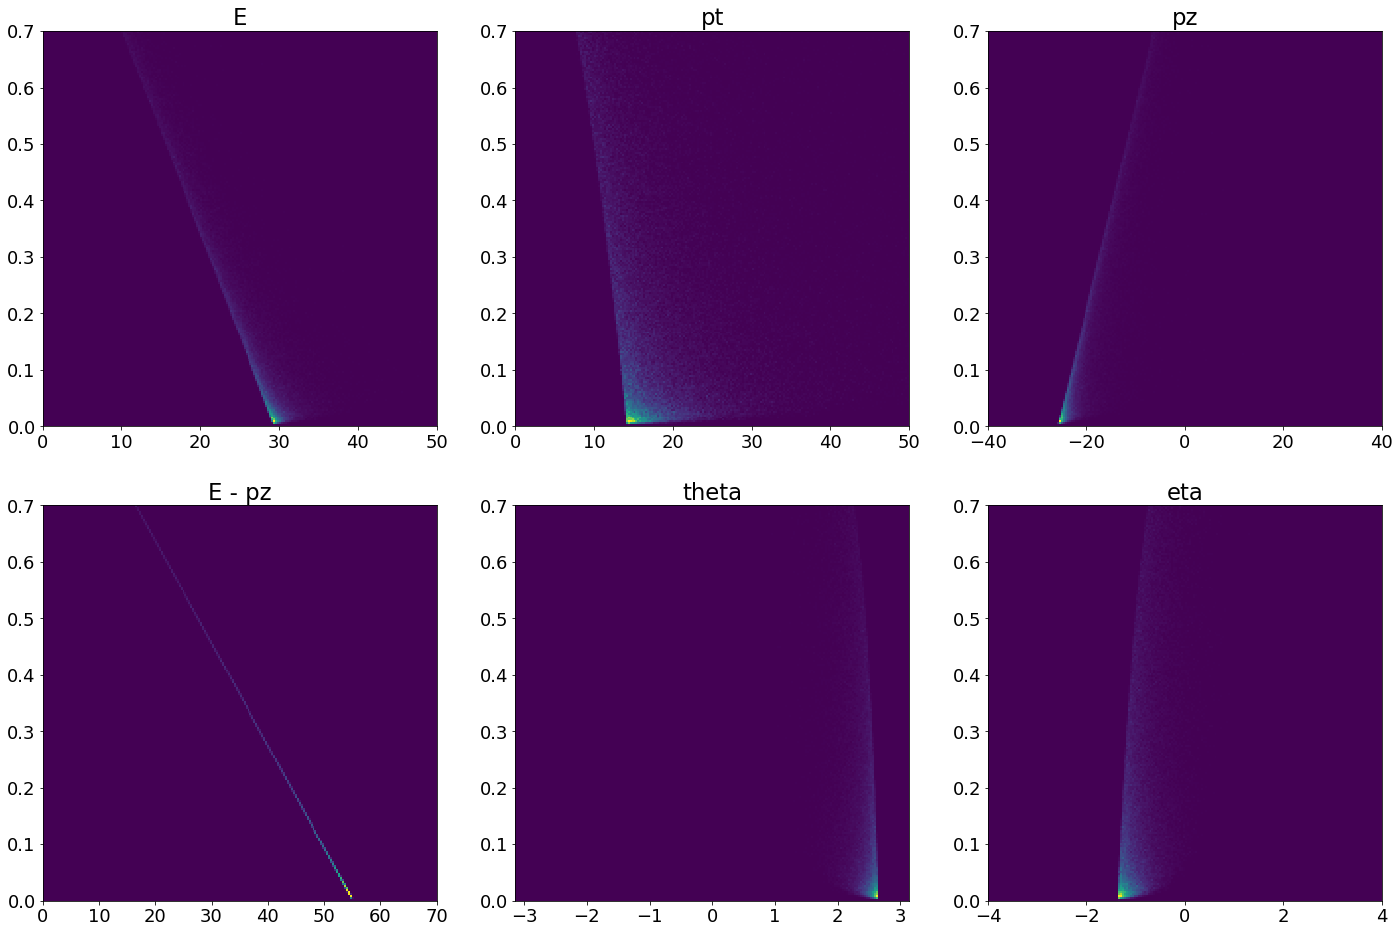

In [10]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

max_gen_y = 0.7

ax[0][0].hist2d(  mc.query(cuts)['gen_e_e'],  mc.query(cuts)['gen_y'], range=([0,50],[0,max_gen_y],), bins=200)
ax[0][1].hist2d(  mc.query(cuts)['gen_e_pt'], mc.query(cuts)['gen_y'],  range=([0,50],[0,max_gen_y],), bins=200)
ax[0][2].hist2d(  mc.query(cuts)['gen_e_pz'], mc.query(cuts)['gen_y'],  range=([-40,40],[0,max_gen_y],), bins=200)

ax[1][0].hist2d( mc.query(cuts)['gen_e_Empz'],  mc.query(cuts)['gen_y'],  range=([0,70],[0,max_gen_y],), bins=200)
ax[1][1].hist2d( mc.query(cuts)['gen_e_theta'], mc.query(cuts)['gen_y'],   range=([-3.1415,3.1415],[0,max_gen_y],), bins=200)
ax[1][2].hist2d( mc.query(cuts)['gen_e_eta'], mc.query(cuts)['gen_y'],   range=([-4,4],[0,max_gen_y],), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n gen y vs various gen e things')

plt.show()

cuts : gen_y < 1


 gen y vs various reconstructed e things


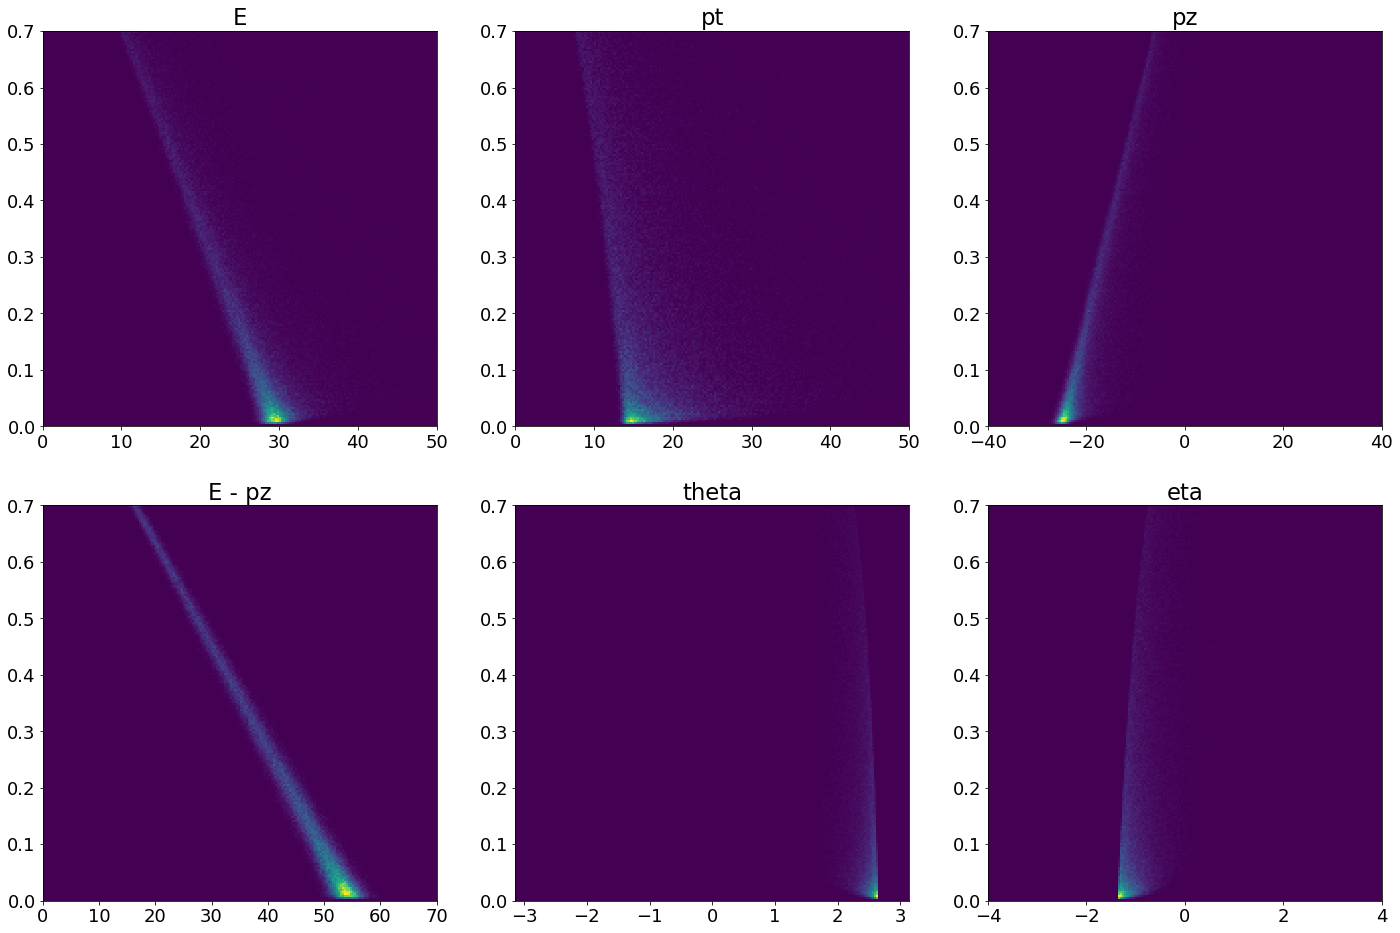

In [11]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

max_gen_y = 0.7

ax[0][0].hist2d(  mc.query(cuts)['e_e'],  mc.query(cuts)['gen_y'], range=([0,50],[0,max_gen_y],), bins=200)
ax[0][1].hist2d(  mc.query(cuts)['e_pt'], mc.query(cuts)['gen_y'],  range=([0,50],[0,max_gen_y],), bins=200)
ax[0][2].hist2d(  mc.query(cuts)['e_pz'], mc.query(cuts)['gen_y'],  range=([-40,40],[0,max_gen_y],), bins=200)

ax[1][0].hist2d( mc.query(cuts)['e_Empz'],  mc.query(cuts)['gen_y'],  range=([0,70],[0,max_gen_y],), bins=200)
ax[1][1].hist2d( mc.query(cuts)['e_theta'], mc.query(cuts)['gen_y'],   range=([-3.1415,3.1415],[0,max_gen_y],), bins=200)
ax[1][2].hist2d( mc.query(cuts)['e_eta'], mc.query(cuts)['gen_y'],   range=([-4,4],[0,max_gen_y],), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n gen y vs various reconstructed e things')

plt.show()

cuts : gen_y < 1


 delta x vs various things


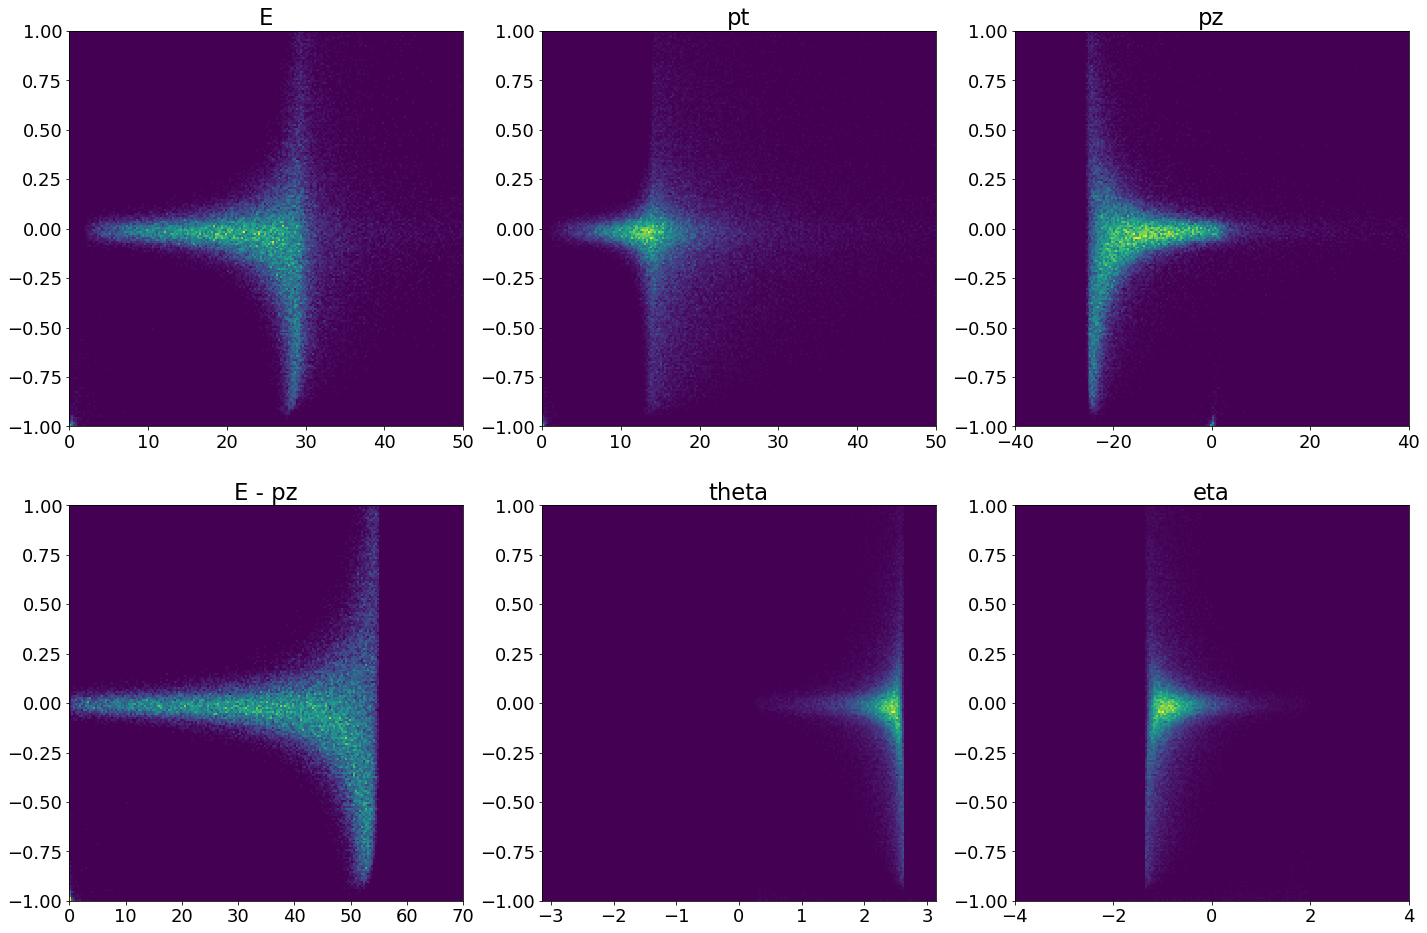

In [12]:
#cuts = 'gen_y < 0.1'
#cuts = 'gen_y < 1'

fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

ax[0][0].hist2d( mc.query(cuts)['e_e'], mc.query(cuts)['dx_e_norm'], range=([0,50],[-1,1]), bins=200)
ax[0][1].hist2d( mc.query(cuts)['e_pt'], mc.query(cuts)['dx_e_norm'], range=([0,50],[-1,1]), bins=200)
ax[0][2].hist2d( mc.query(cuts)['e_pz'], mc.query(cuts)['dx_e_norm'], range=([-40,40],[-1,1]), bins=200)

ax[1][0].hist2d( mc.query(cuts)['e_Empz'], mc.query(cuts)['dx_e_norm'], range=([0,70],[-1,1]), bins=200)
ax[1][1].hist2d( mc.query(cuts)['e_theta'], mc.query(cuts)['dx_e_norm'], range=([-3.1415,3.1415],[-1,1]), bins=200)
ax[1][2].hist2d( mc.query(cuts)['e_eta'], mc.query(cuts)['dx_e_norm'], range=([-4,4],[-1,1]), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n delta x vs various things')

plt.show()

cuts : gen_y < 1


 delta y vs various things


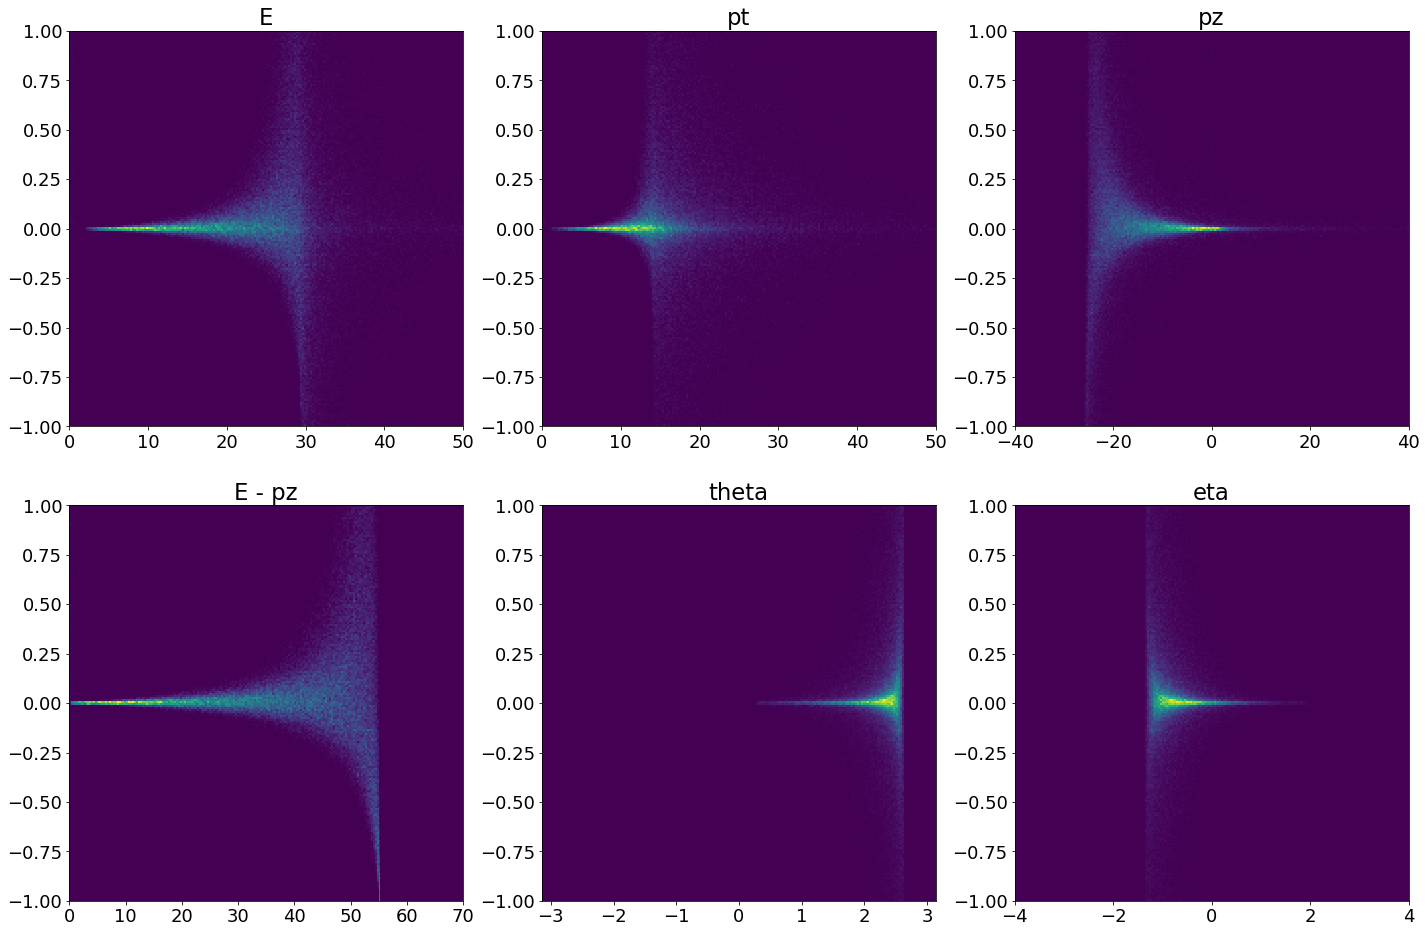

In [13]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

ax[0][0].hist2d( mc.query(cuts)['e_e'], mc.query(cuts)['dy_e_norm'], range=([0,50],[-1,1]), bins=200)
ax[0][1].hist2d( mc.query(cuts)['e_pt'], mc.query(cuts)['dy_e_norm'], range=([0,50],[-1,1]), bins=200)
ax[0][2].hist2d( mc.query(cuts)['e_pz'], mc.query(cuts)['dy_e_norm'], range=([-40,40],[-1,1]), bins=200)

ax[1][0].hist2d( mc.query(cuts)['e_Empz'], mc.query(cuts)['dy_e_norm'], range=([0,70],[-1,1]), bins=200)
ax[1][1].hist2d( mc.query(cuts)['e_theta'], mc.query(cuts)['dy_e_norm'], range=([-3.1415,3.1415],[-1,1]), bins=200)
ax[1][2].hist2d( mc.query(cuts)['e_eta'], mc.query(cuts)['dy_e_norm'], range=([-4,4],[-1,1]), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n delta y vs various things')

plt.show()

cuts : gen_y < 1


 delta x / delta <something> vs various things


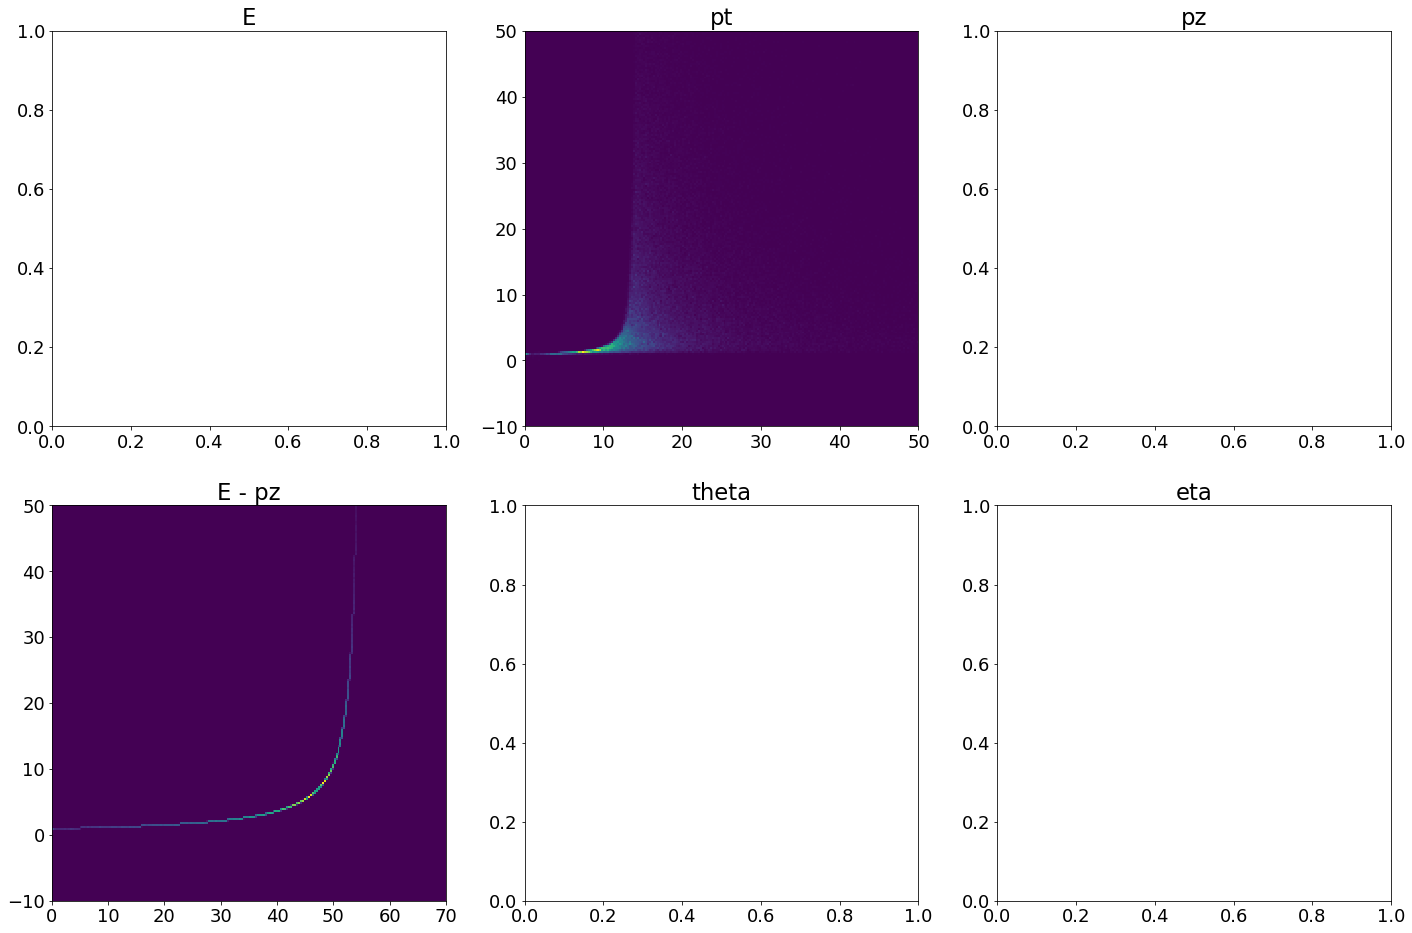

In [28]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

#ax[0][0].hist2d( mc.query(cuts)['e_e'], mc.query(cuts)['dy_e_norm'], range=([0,50],[-1,1]), bins=200)
ax[0][1].hist2d( mc.query(cuts)['e_pt'], mc.query(cuts)['dx_e_norm_over_de_pt_norm'], range=([0,50],[-10,50]), bins=200)
#ax[0][2].hist2d( mc.query(cuts)['e_pz'], mc.query(cuts)['dy_e_norm'], range=([-40,40],[-1,1]), bins=200)

ax[1][0].hist2d( mc.query(cuts)['e_Empz'], mc.query(cuts)['dx_e_norm_over_de_Empz_norm'], range=([0,70],[-10,50]), bins=200)
#ax[1][1].hist2d( mc.query(cuts)['e_theta'], mc.query(cuts)['dy_e_norm'], range=([-3.1415,3.1415],[-1,1]), bins=200)
#ax[1][2].hist2d( mc.query(cuts)['e_eta'], mc.query(cuts)['dy_e_norm'], range=([-4,4],[-1,1]), bins=200)

ax[0][0].set_title('E')
ax[0][1].set_title('pt')
ax[0][2].set_title('pz')
ax[1][0].set_title('E - pz')
ax[1][1].set_title('theta')
ax[1][2].set_title('eta')

print('\n\n delta x / delta <something> vs various things')

plt.show()